In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import time, os
from tqdm import tqdm
from sklearn import datasets

In [2]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [3]:
from torch import distributions
from torch.distributions import MultivariateNormal

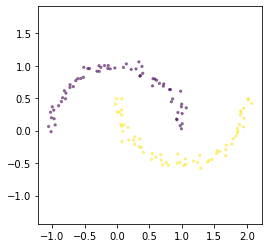

In [4]:
# Lightweight datasets

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)
        x,c = moons
        x = x.astype(np.float32)
        c = c.astype(np.long)
        return torch.from_numpy(x), torch.from_numpy(c)

d = DatasetMoons()

x,c = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5, c=c)
plt.axis('equal');

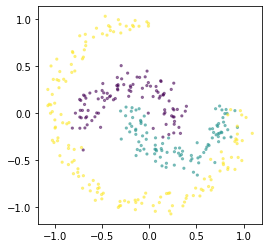

In [5]:
class DatasetMoons:
    """ two half-moons """
    def __init__(self, total_points = 1000, seed=None):
        if seed is not None:
            np.random.seed(seed) ## 148, 249
            
        xxc, yc = datasets.make_circles(n_samples=400, factor=.5,
                                        noise=.07)
        idx = yc==0
        xxc = xxc[idx]
        yc = yc[idx]
        idx = (xxc[:,0]+xxc[:,1]<1)
        xxc = xxc[idx]
        yc = yc[idx]

        xxm, ym = datasets.make_moons(n_samples=200, noise=.15)
        xxm = xxm/2 - 0.2
        xx = np.concatenate((xxm, xxc), axis=0)
        y = np.concatenate((ym, yc+2), axis=0)
        
        self.x = xx
        self.c = y

    
    def sample(self, n):
        if n > len(self.x):
            n = len(self.x)
        x = self.x.astype(np.float32)
        c = self.c.astype(np.long)
        return torch.from_numpy(x), torch.from_numpy(c)

d = DatasetMoons()

x,c = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5, c=c)
plt.axis('equal');

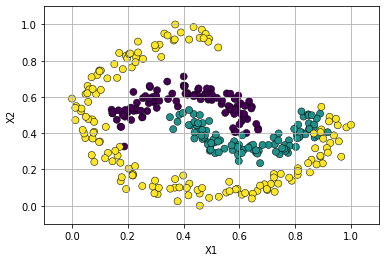

In [6]:
np.random.seed(249) ## 148, 249

xxc, yc = datasets.make_circles(n_samples=400, factor=.5,
                                      noise=.07)
idx = yc==0
xxc = xxc[idx]
yc = yc[idx]

idx = (xxc[:,0]+xxc[:,1]<1)
xxc = xxc[idx]
yc = yc[idx]


xxm, ym = datasets.make_moons(n_samples=200, noise=.15)
xxm = xxm/2 - 0.2

xx = np.concatenate((xxm, xxc), axis=0)
y = np.concatenate((ym, yc+2), axis=0)

## MinMax Normalization
x1 = xx[:,0]
x2 = xx[:,1]
x1 = (x1-x1.min())/(x1.max()-x1.min())
x2 = (x2-x2.min())/(x2.max()-x2.min())
xx = np.column_stack((x1,x2))

%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)

(x1min, x1max) = -0.1, 1.1
plt.xlim((x1min, x1max))
plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [7]:
# class ConnectedClassifier(nn.Module):
    
#     def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
#         super().__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.num_sets = num_sets
#         self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
#         self.linear = nn.Linear(input_dim, num_sets)
#         self.linear.bias.data *= 0
#         self.linear.weight.data *= 0.1
#         self.cls_weight = nn.Parameter(torch.ones(num_sets, output_dim)/output_dim)
#         self.cls_confidence = None
        
        
#     def forward(self, x):
#         x = self.linear(x)
#         x = torch.softmax(x*self.inv_temp, dim=1)
#         self.cls_confidence = x
# #         c = torch.softmax(self.cls_weight, dim=1)
#         c = self.cls_weight
#         return x@c ## since both are normalized, it is also normalized

In [8]:
# ### for 10 num_sets
# prob = torch.softmax(torch.randn(2, 10), dim=1)
# prob.sum(dim=1, keepdim=True)

In [9]:
# ### for 5 classes
# weight = torch.softmax(torch.randn(10, 5), dim=1)
# weight.sum(dim=1, keepdim=True)

In [10]:
# (prob@weight).sum(dim=1)

In [45]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(input_dim, num_sets)*2-1)
        self.cls_weight = nn.Parameter(torch.ones(num_sets, output_dim)/output_dim)
        self.cls_confidence = None
        
        
    def forward(self, x):
        dists = torch.norm(x.unsqueeze(-1)-self.centers.unsqueeze(0), dim=1)
        x = torch.softmax(dists*self.inv_temp, dim=1)
        self.cls_confidence = x
        c = torch.softmax(self.cls_weight, dim=1)
#         c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

In [46]:
# cent = torch.rand(2, 5)*2-1
# cent.shape

In [47]:
# dat = torch.randn(3, 2)
# dat.shape

In [48]:
# dists = torch.norm(dat.unsqueeze(-1)-cent.unsqueeze(0), dim=1)

In [49]:
# torch.softmax(dists, dim=1)

In [50]:
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))

actf = irf.Swish
flows = [
    ActNorm(2),
    irf.ResidualFlow(2, [100], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [100], activation=actf),
    ActNorm(2),
#     irf.ResidualFlow(2, [100], activation=actf),
#     ActNorm(2),
#     irf.ResidualFlow(2, [100], activation=actf),
#     ActNorm(2),
        ]

model = SequentialFlow(flows)

In [51]:
# classifier = ConnectedClassifier(2, 50, 3)
classifier = ConnectedClassifier_SoftKMeans(2, 50, 3)

In [52]:
model

SequentialFlow(
  (flows): ModuleList(
    (0): ActNorm()
    (1): ResidualFlow(
      (resblock): ModuleList(
        (0): Linear(in_features=2, out_features=100, bias=True)
        (1): Swish()
        (2): Linear(in_features=100, out_features=2, bias=True)
      )
    )
    (2): ActNorm()
    (3): ResidualFlow(
      (resblock): ModuleList(
        (0): Linear(in_features=2, out_features=100, bias=True)
        (1): Swish()
        (2): Linear(in_features=100, out_features=2, bias=True)
      )
    )
    (4): ActNorm()
  )
)

In [53]:
classifier

ConnectedClassifier_SoftKMeans()

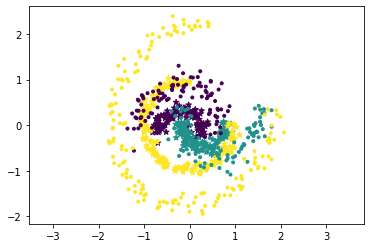

In [54]:
x,c = d.sample(128)
z, logDetJ = model(x, True)
z = z.data.detach()
plt.scatter(x[:,0], x[:,1], marker='*', c=c)
plt.scatter(z[:,0], z[:,1], marker='.', c=c)
plt.axis('equal');

In [55]:
# jpt text to stop execution

## Model Train

In [56]:
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()),
                       lr=0.001, weight_decay=1e-5) # todo tune WD
# optimizer = optim.SGD(model.parameters(), lr=0.1)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  1018


In [57]:
model.train()
losses = []
NUM = 512
for k in tqdm(range(1000*2+1)):
    optimizer.zero_grad()
    
    x,c = d.sample(NUM)
    z = model(x, False)
#     print(z.shape)
    y = classifier(z)
#     print(y.shape)
#     print(c.shape, c.dtype)
    loss = criterion(y, c)
    loss.backward()
    optimizer.step()
    
#     break
    if k % 200 == 0:
        losses.append(float(loss))
        print("Loss:", k, losses[-1])
        print("logDetJ:", logDetJ.data.min(), logDetJ.data.max())


  0%|          | 0/2001 [00:00<?, ?it/s]

Loss: 0 1.0986104011535645
logDetJ: tensor(1.3071) tensor(1.3305)


 11%|█         | 215/2001 [00:02<00:18, 94.27it/s]

Loss: 200 1.0671757459640503
logDetJ: tensor(1.3071) tensor(1.3305)


 13%|█▎        | 267/2001 [00:02<00:18, 93.93it/s]


KeyboardInterrupt: 

In [43]:
asdfsdf

NameError: name 'asdfsdf' is not defined

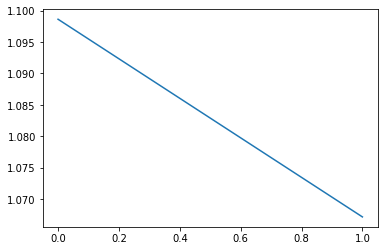

In [58]:
plt.plot(losses)

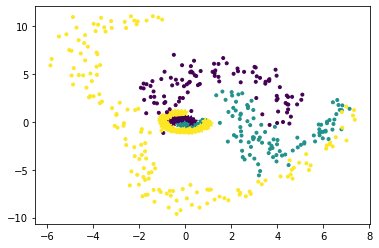

In [59]:
with torch.no_grad():
    x,c = d.sample(200)
    z = model(x, False)
plt.scatter(x[:,0], x[:,1], marker='*', c=c)
plt.scatter(z[:,0], z[:,1], marker='.', c=c)   

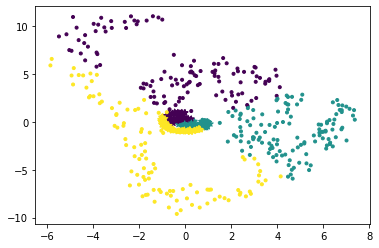

In [60]:
with torch.no_grad():
    x,c = d.sample(200)
    z = model(x, False)
    y = torch.argmax(classifier(z), dim=1)
plt.scatter(x[:,0], x[:,1], marker='*', c=y.reshape(-1))
plt.scatter(z[:,0], z[:,1], marker='.', c=y.reshape(-1))   

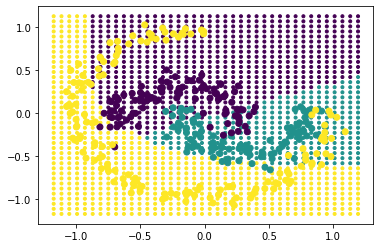

In [61]:
model.eval()

ng = 40
_a,_b,_c,_d = x[:,0].min()-0.1,x[:,0].max()+0.1,x[:,1].min()-0.1,x[:,1].max()+0.1
xx, yy = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv.reshape(-1), yv.reshape(-1)], axis=-1)
x_ = torch.Tensor(xy)

with torch.no_grad():
#     x,c = d.sample(200)
    z = model(x_, False)
    y = torch.argmax(classifier(z), dim=1)
    
plt.scatter(x_[:,0], x_[:,1], marker='.', c=y.reshape(-1))
x,c = d.sample(200)
plt.scatter(x[:,0], x[:,1], marker='o', c=c.reshape(-1))

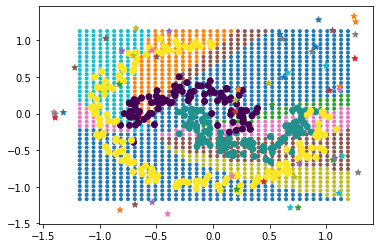

In [62]:
cls = torch.argmax(classifier.cls_confidence, dim=1)
# for i, u in enumerate(torch.unique(cls)):
#     cls[cls==u] = i

plt.scatter(x_[:,0], x_[:,1], marker='.', c=cls, cmap='tab10')
plt.scatter(x[:,0], x[:,1], marker='o', c=c.reshape(-1))

plt.scatter(*classifier.centers.data, marker='*', c=list(range(classifier.num_sets)), cmap='tab10')

In [63]:
classifier.centers.data

tensor([[ 0.6234,  0.9095,  0.9334, -1.3194,  0.5938, -0.8195,  1.2606,  1.2457,
          0.2233,  1.1199,  0.7532,  1.0593,  0.5225, -0.8252,  0.2113,  0.1955,
         -1.3926,  1.2537,  0.4485,  1.0295, -0.3853,  1.0771, -0.8018,  0.7631,
         -0.5347, -0.4964,  1.0557, -0.9453, -1.2190, -0.6870,  0.1702, -0.3988,
          1.1192, -1.4042, -0.5370,  1.2825,  0.8759,  1.2581, -1.3911,  0.6140,
          0.7224,  0.1989, -0.6787,  0.4934, -0.7018,  1.1433,  0.6609,  0.6830,
          0.9961,  1.1116],
        [ 0.4931,  0.9080,  1.2810,  0.0141,  1.0826, -1.3183,  1.2523,  1.3296,
          0.3263,  0.3645, -1.2868, -0.6346,  0.1164,  0.3996, -1.0387,  0.0230,
         -0.0564,  0.7523, -0.9321,  0.3154,  1.1232, -0.6105,  0.8568, -0.6842,
         -1.2127,  0.7741,  1.1357,  1.0265,  0.6266, -1.2462, -0.8550, -1.3723,
          0.3269,  0.0183,  0.8606, -0.8070,  0.8434,  1.0792, -0.0053,  1.0194,
         -0.8696,  0.1825,  1.1656,  0.4123,  0.7891, -0.5809,  0.5580, -1.2855,


In [360]:
list(range(len(classifier.centers)))

[0, 1]

In [361]:
classifier.centers.shape

torch.Size([2, 50])

In [353]:
classifier.centers.data.numpy()

SyntaxError: can't use starred expression here (<ipython-input-353-ec06159bad21>, line 1)

In [334]:
classifier.inv_temp

Parameter containing:
tensor([2.8228], requires_grad=True)

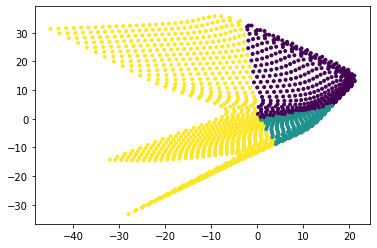

In [335]:
plt.scatter(z[:,0], z[:,1], marker='.', c=y.reshape(-1))   

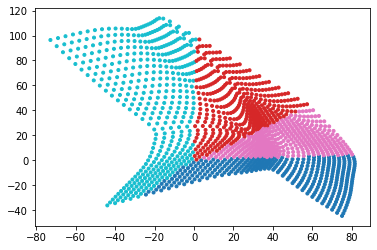

In [299]:
plt.scatter(z[:,0], z[:,1], marker='.', c=cls, cmap='tab10')   

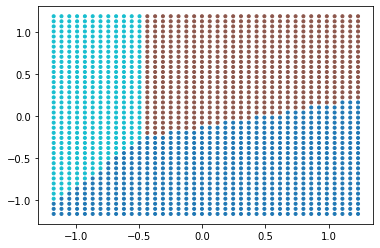

In [300]:
classifier(x_)
cls_ = torch.argmax(classifier.cls_confidence, dim=1)
for i, u in enumerate(torch.unique(cls_)):
    cls_[cls_==u] = i
plt.scatter(x_[:,0], x_[:,1], marker='.', c=cls_, cmap='tab10') 

torch.Size([400, 2])


Text(0.5, 1.0, 'x -> z')

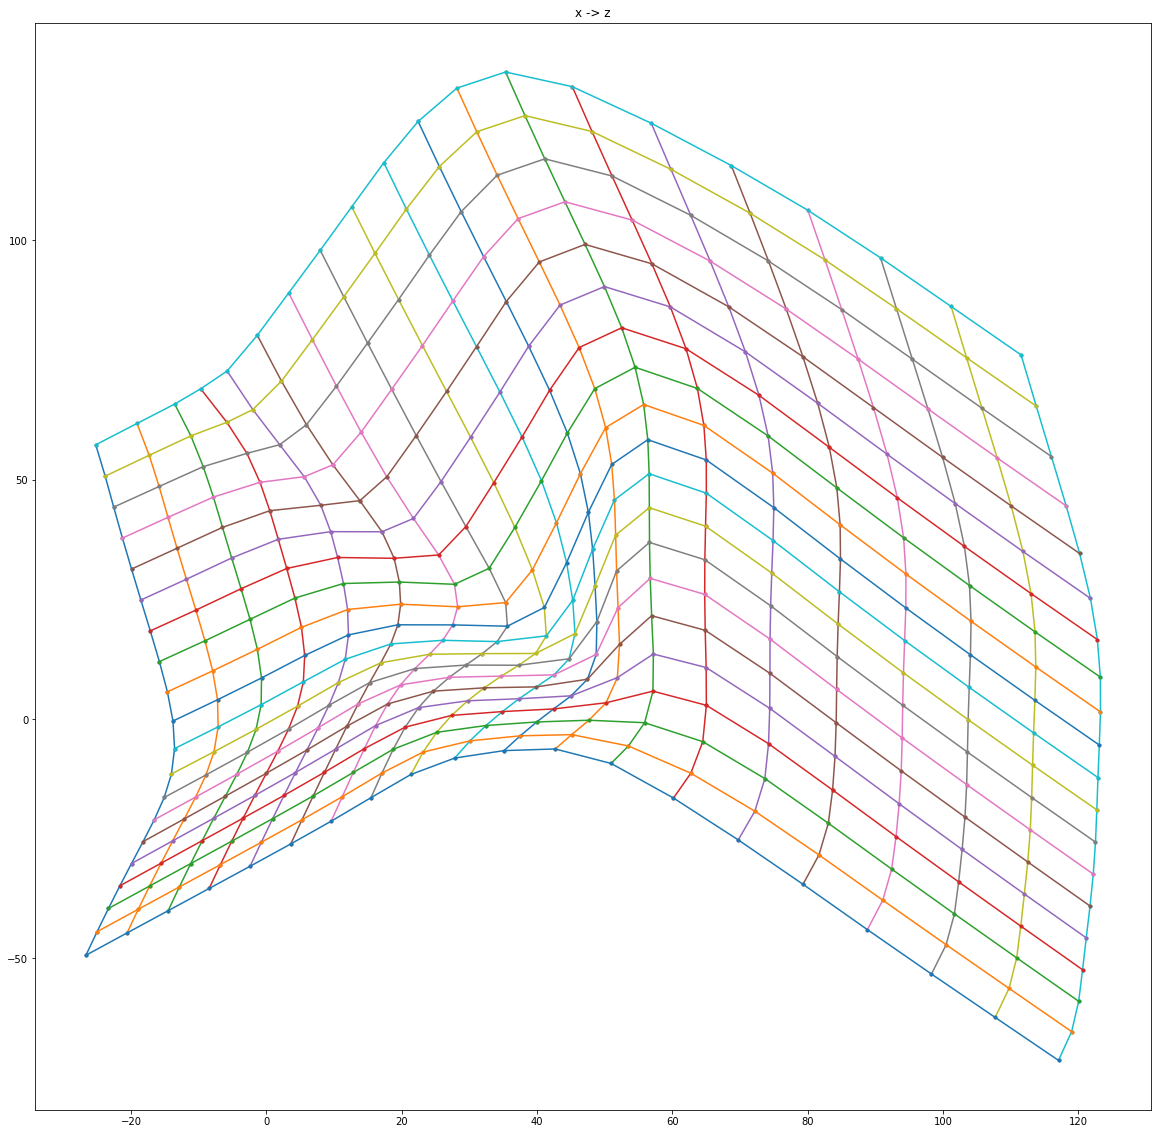

In [221]:
model.eval()

ng = 20
_a,_b,_c,_d = x[:,0].min()-0.1,x[:,0].max()+0.1,x[:,1].min()-0.1,x[:,1].max()+0.1
xx, yy = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv.reshape(-1), yv.reshape(-1)], axis=-1)
x = torch.Tensor(xy)
z = model(x)
print(z.shape)

x = x.detach().numpy()
z = z.detach().numpy()
plt.figure(figsize=(20,20))
plt.scatter(z[:,0], z[:,1], c='r', s=5)
z = z.reshape(ng, ng, -1)
for i in range(ng):
    plt.plot(z[:, i, 0], z[:, i, 1], marker='.')
for i in range(ng):
    plt.plot(z[i, :, 0], z[i, :, 1], marker='.')
    
plt.title('x -> z')